# 케라스를 사용한 신경망 구현

Keras 패키지는 Theano 또는 TensorFlow를 계산 엔진으로 사용하는 파이썬 패키지다. 신경망을 구성하기 위한 각 구성요소를 클래스로 제공하기 때문에 이를 간단히 연결하기만 하면 쉽게 신경망을 구현할 수 있다. 이 글에서는 버전 텐서플로우 2.0-beta에 추가된 케라스 2.2.4-tf 버전을 기준으로 설명한다.

In [1]:
# %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
from tensorflow import keras
keras.__version__

'2.4.0'

## 예제 데이터

Keras는 다음과 같은 샘플데이터를 제공한다.

* CIFAR10 이미지
  * 10 종류의 카테고리 라벨을 가지는 50,000 개의 32x32 해상도 컬러 트레이닝 이미지와 10,000 개의 테스트 이미지

* CIFAR100 이미지
  * 100 종류의 카테고리 라벨을 가지는 50,000 개의 32x32 해상도 컬러 트레이닝 이미지와 10,000 개의 테스트 이미지

* IMDB 영화 감상
  * positive/negative 라벨을 가지는 25,000 영화 감상 데이터
  * 텍스트 단어는 숫자로 인코딩되어 있음

* 로이터 뉴스 토픽 
  * 46 종류의 토픽 라벨을 가지는 11,228 개의 로이터 뉴스 텍스트
  * 텍스트 단어는 숫자로 인코딩되어 있음

* MNIST 숫자 이미지
  * 0부터 9까지의 숫자에 대한 28x28 단색 이미지
  * 트레이딩 데이터 60,000개. 테스트 이미지 10,000개

* MNIST 패션 이미지
  * 10 종류의 의류 대한 28x28 단색 이미지
  * 트레이딩 데이터 60,000개. 테스트 이미지 10,000개

* Boston housing price
  * 보스턴 주택 가격 데이터

Keras를 사용하는 방법은 어렵지 않기 때문에 바로 MNIST 데이터를 이용해 신경망을 구현하는 예를 보인다.

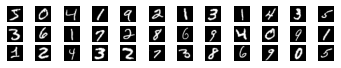

In [3]:
mnist = keras.datasets.mnist
(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

import matplotlib.pylab as plt

plt.figure(figsize=(6, 1))
for i in range(36):
    plt.subplot(3, 12, i+1)
    plt.imshow(X_train0[i], cmap="gray")
    plt.axis("off")
plt.show()

Keras의 MNIST 이미지 데이터는 28x28로 scikit-learn보다 고해상도이다.

In [4]:
print(X_train0.shape, X_train0.dtype)
print(y_train0.shape, y_train0.dtype)
print(X_test0.shape, X_test0.dtype)
print(y_test0.shape, y_test0.dtype)

(60000, 28, 28) uint8
(60000,) uint8
(10000, 28, 28) uint8
(10000,) uint8


데이터를 `float` 타입으로 변환 후 스케일링한다. 이는 이미지를 전처리하는 보편적인 방법 중 하나이다.

In [5]:
X_train = X_train0.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test0.reshape(10000, 784).astype('float32') / 255.0
print(X_train.shape, X_train.dtype)

(60000, 784) float32


정답데이터는 라벨에 해당하는 숫자로 되어 있다. 

In [6]:
y_train0[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

이 값을`keras.np_utils.categorical()`을 사용하여 원핫인코딩(One-Hot-Encoding)로 변환한다.

In [7]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train0, 10)
Y_test = to_categorical(y_test0, 10)
Y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## 신경망 구현 순서

Keras 를 사용하면 다음과 같은 순서로 신경망을 구성할 수 있다.

1. ``Sequential`` 모형 클래스 객체 생성
1. ``add`` 메서드로 레이어 추가. 
   * 입력단부터 순차적으로 추가한다.
   * 레이어는 출력 뉴런 갯수를 첫번째 인수로 받는다.
   * 최초의 레이어는 ``input_dim`` 인수로 입력 크기를 설정해야 한다.
   * ``activation`` 인수로 활성화함수 설정
1. ``compile`` 메서드로 모형 완성. 
   * ``loss``인수로 비용함수 설정
   * ``optimizer`` 인수로 최적화 알고리즘 설정
   * ``metrics`` 인수로 트레이닝 단계에서 기록할 성능 기준 설정
1. ``fit`` 메서드로 트레이닝
   * ``nb_epoch`` 로 에포크(epoch) 횟수 설정
   * ``batch_size`` 로 배치크기(batch size) 설정
   * ``verbose``는 학습 중 출력되는 문구를 설정하는 것으로, 주피터노트북(Jupyter Notebook)을 사용할 때는 ``verbose=2``로 설정하여 진행 막대(progress bar)가 나오지 않도록 설정한다.

다음은 간단한 신경망 모형을 방금 설명한 방법으로 구현한 것이다.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# tf.random.set_seed(0)

model = Sequential()
model.add(Dense(15, input_dim=784, activation="sigmoid"))
model.add(Dense(10, activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

만들어진 모형은  `summary` 명령으로 모델 내부의 ``layers`` 리스트를 살펴봄으로써 내부 구조를 확인할 수 있다.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                11775     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                160       
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


layers 속성으로 각 레이어의 특성을 살펴볼 수도 있다.

In [10]:
l1 = model.layers[0]
l2 = model.layers[1]

print(l1.name, type(l1), l1.output_shape, l1.activation.__name__, l1.count_params())
print(l2.name, type(l1), l2.output_shape, l2.activation.__name__, l2.count_params())

dense <class 'tensorflow.python.keras.layers.core.Dense'> (None, 15) sigmoid 11775
dense_1 <class 'tensorflow.python.keras.layers.core.Dense'> (None, 10) sigmoid 160


모델을 완성했다면 ``fit`` 메서드로 트레이닝을 시작한다.

In [11]:
%%time
hist = model.fit(X_train, Y_train,
                 epochs=10, batch_size=100,
                 validation_data=(X_test, Y_test),
                 verbose=2)

Epoch 1/10
600/600 - 1s - loss: 0.0984 - accuracy: 0.2622 - val_loss: 0.0876 - val_accuracy: 0.3874
Epoch 2/10
600/600 - 1s - loss: 0.0861 - accuracy: 0.3746 - val_loss: 0.0840 - val_accuracy: 0.3796
Epoch 3/10
600/600 - 1s - loss: 0.0817 - accuracy: 0.4141 - val_loss: 0.0789 - val_accuracy: 0.4800
Epoch 4/10
600/600 - 1s - loss: 0.0765 - accuracy: 0.4996 - val_loss: 0.0734 - val_accuracy: 0.5315
Epoch 5/10
600/600 - 1s - loss: 0.0710 - accuracy: 0.5500 - val_loss: 0.0681 - val_accuracy: 0.5890
Epoch 6/10
600/600 - 1s - loss: 0.0661 - accuracy: 0.6113 - val_loss: 0.0635 - val_accuracy: 0.6482
Epoch 7/10
600/600 - 1s - loss: 0.0618 - accuracy: 0.6730 - val_loss: 0.0593 - val_accuracy: 0.7107
Epoch 8/10
600/600 - 1s - loss: 0.0577 - accuracy: 0.7193 - val_loss: 0.0554 - val_accuracy: 0.7446
Epoch 9/10
600/600 - 1s - loss: 0.0540 - accuracy: 0.7463 - val_loss: 0.0518 - val_accuracy: 0.7669
Epoch 10/10
600/600 - 1s - loss: 0.0506 - accuracy: 0.7674 - val_loss: 0.0485 - val_accuracy: 0.7842

학습이 끝나면 기록된 변수를 확인한다. 다음 두 그래프는 방금 학습 시킨 모델의 비용함수와 성능지표에 대한 것이다. 

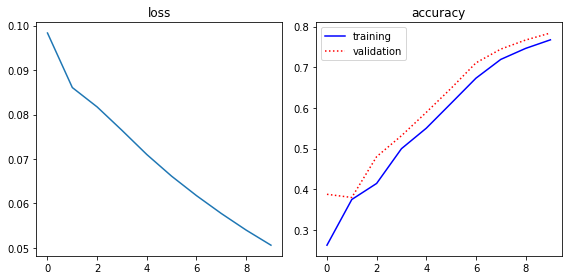

In [12]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("accuracy")
plt.plot(hist.history['accuracy'], 'b-', label="training")
plt.plot(hist.history['val_accuracy'], 'r:', label="validation")
plt.legend()
plt.tight_layout()
plt.show()

## 가중치 정보

트레이닝이 끝난 모형의 가중치 정보는 `get_weights` 메서드로 구할 수 있다. 이 메서드는 신경망 모형에서 사용된 가중치 $w$ 값과 $b$ 값을 출력한다.

In [13]:
# 첫번째 레이어
w1 = l1.get_weights()
w1[0].shape, w1[1].shape

((784, 15), (15,))

In [14]:
# 두번째 레이어
w2 = l2.get_weights()
w2[0].shape, w2[1].shape

((15, 10), (10,))

## 모형의 사용

트레이닝이 끝난 모형은 ``predict`` 메서드로 y 값을 출력하거나 출력된 y값을 각 클래스에 대한 판별함수로 가정하고 ``predict_classes`` 메서드로 분류를 수행할 수 있다. 예로 테스트 데이터셋의 첫번째 이미지를 예측하면 다음과 같다. 

In [15]:
model.predict(X_test[:1, :])

array([[0.07408056, 0.06462833, 0.06313288, 0.04273161, 0.11020827,
        0.09650835, 0.04367584, 0.77508116, 0.0551582 , 0.19015625]],
      dtype=float32)

In [16]:
model.predict_classes(X_test[:1, :], verbose=0)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([7], dtype=int64)

테스트 데이터셋의 첫번째 이미지를 출력해보면 다음처럼 실제로 7이 나온다

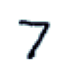

In [17]:
plt.figure(figsize=(1, 1))
plt.imshow(X_test0[0], cmap=plt.cm.bone_r)
plt.grid(False)
plt.axis("off")
plt.show()

## 모형의 저장

트레이닝이 끝난 모형은 ``save`` 메서드로 가중치와 함께 "hdf5" 형식으로 저장하였다가 나중에 ``load`` 명령으로 불러 사용할 수 있다.

In [18]:
print(model.predict(X_test[:1, :]))

[[0.07408056 0.06462833 0.06313288 0.04273161 0.11020827 0.09650835
  0.04367584 0.77508116 0.0551582  0.19015625]]


In [19]:
print(model.predict_classes(X_test[:1, :], verbose=0))

[7]


In [20]:
model.save('my_model.hdf5')
del model

In [21]:
model.summary()

NameError: name 'model' is not defined

In [22]:
from tensorflow.keras.models import load_model

model2 = load_model('my_model.hdf5')


In [23]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                11775     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                160       
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


In [24]:
print(model2.predict_classes(X_test[:1, :], verbose=0))

[7]
